In [3]:
# installing missing packages
%%capture
import sys

!pip install category_encoders==2.*
!pip install eli5
!pip install pdpbox
!pip install shap
!pip install xgboost
!pip install pandas_profiling
!pip install matplotlib==2.*

In [5]:
# import block

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import eli5
from eli5.sklearn import PermutationImportance
from pdpbox.pdp import pdp_isolate, pdp_plot
import shap
from sklearn.ensemble import GradientBoostingClassifier
# pd.options.mode.chained_assignment = None  # default='warn'

In [6]:
ufc = pd.read_csv('https://raw.githubusercontent.com/ameralhomdy/UFC_prediction_project/master/ufc_combined.csv')

ufc.head()

Unnamed: 0              fighter1             fighter2  winner  \
0           0  Santiago Ponzinibbio           Neil Magny       1   
1           1         Ricardo Lamas        Darren Elkins       1   
2           2         Johnny Walker  Khalil Rountree Jr.       1   
3           3        Cezar Ferreira         Ian Heinisch       0   
4           4           Marlon Vera       Guido Cannetti       1   

        weight_class title_fight  method  end_round  fight_year  win_fighter1  \
0       Welterweight           f  KO/TKO          4        2018            28   
1      Featherweight           f  KO/TKO          3        2018            19   
2  Light Heavyweight           f  KO/TKO          1        2018            15   
3       Middleweight           f     DEC          3        2018            14   
4       Bantamweight           f     SUB          2        2018            12   

   ...  SLpM_fighter2  Str_Acc_fighter2  SApM_fighter2 Str_Def_fighter2  \
0  ...           3.86              46.0           2.22             56.0   
1  ...           3.36              37.0           2.83             53.0   
2  ...           2.30              34.0           3.29             38.0   
3  ...           3.49              58.0           1.67             52.0   
4  ...           2.80              52.0           1.95             51.0   

  TD_Avg_fighter2 TD_Acc_fighter2  TD_Def_fighter2  Sub_Avg_fighter2  \
0            2.62            46.0             60.0               0.3   
1            2.68            35.0             57.0               1.3   
2            0.00             0.0             50.0               0.3   
3            0.81            14.0             50.0               1.6   
4            2.80            50.0             75.0               0.3   

   win%_fighter2  born_year_fighter2  
0      72.413795                1987  
1      78.125000                1984  
2      66.666664                1990  
3      92.307690                1988  
4      61.538460                1979  

[5 rows x 43 columns]

In [30]:
# getting a general overview of the data

import pandas_profiling
pandas_profiling.ProfileReport(ufc)

In [8]:
ufc.describe()

Unnamed: 0       winner    end_round   fight_year  win_fighter1  \
count  4591.000000  4591.000000  4591.000000  4591.000000   4591.000000   
mean   2295.000000     0.499673     2.318449  2012.485297     18.209105   
std    1325.451873     0.500054     0.995680     4.340787      9.189879   
min       0.000000     0.000000     1.000000  1993.000000      0.000000   
25%    1147.500000     0.000000     1.000000  2010.000000     12.000000   
50%    2295.000000     0.000000     3.000000  2013.000000     17.000000   
75%    3442.500000     1.000000     3.000000  2016.000000     23.000000   
max    4590.000000     1.000000     5.000000  2018.000000     88.000000   

       lose_fighter1  draw_fighter1  nc_fighter1  SLpM_fighter1  \
count    4591.000000    4591.000000  4591.000000    4591.000000   
mean        7.067523       0.261163     0.203659       3.038713   
std         4.160795       0.706932     0.445402       1.162678   
min         0.000000       0.000000     0.000000       0.000000   
25%         4.000000       0.000000     0.000000       2.220000   
50%         6.000000       0.000000     0.000000       2.960000   
75%        10.000000       0.000000     0.000000       3.710000   
max        33.000000      10.000000     3.000000      10.830000   

       Str_Acc_fighter1  ...  nc_fighter2  SLpM_fighter2  Str_Acc_fighter2  \
count       4591.000000  ...   4591.00000    4591.000000       4591.000000   
mean          42.788717  ...      0.20758       3.051292         43.051841   
std            8.574358  ...      0.44750       1.211596          8.512936   
min            0.000000  ...      0.00000       0.000000          0.000000   
25%           38.000000  ...      0.00000       2.220000         38.000000   
50%           43.000000  ...      0.00000       2.970000         43.000000   
75%           48.000000  ...      0.00000       3.710000         48.000000   
max          100.000000  ...      2.00000      12.940000        100.000000   

       SApM_fighter2  Str_Def_fighter2  TD_Avg_fighter2  TD_Acc_fighter2  \
count    4591.000000       4591.000000      4591.000000      4591.000000   
mean        3.104025         55.824875         1.651261        39.726203   
std         1.249050          8.381159         1.315888        20.968619   
min         0.000000          9.000000         0.000000         0.000000   
25%         2.330000         51.000000         0.650000        28.000000   
50%         2.940000         57.000000         1.400000        40.000000   
75%         3.640000         62.000000         2.410000        50.000000   
max        22.500000        100.000000        13.950000       100.000000   

       TD_Def_fighter2  Sub_Avg_fighter2  win%_fighter2  
count       4591.00000       4591.000000    4591.000000  
mean          58.18166          0.748203      71.077670  
std           22.41266          0.878889      10.413941  
min            0.00000          0.000000       0.000000  
25%           47.00000          0.100000      64.285710  
50%           62.00000          0.500000      71.428570  
75%           73.00000          1.000000      77.777780  
max          100.00000         12.100000     100.000000  

[8 rows x 30 columns]

In [32]:
baseline_score = 1 - ufc['winner'].mean()
print('If we predicted that fighter1 lost everytime')
print(f'Then our baseline Accuracy Score is:{baseline_score}')

If we predicted that fighter1 lost everytime
Then our baseline Accuracy Score is:0.5003267262034415


In [10]:
# dropping useless columns and looking for data leakage

dropped_columns = ['method', 'end_round', 'Unnamed: 0', 'stance_fighter1', 'stance_fighter2']

ufc = ufc.drop(columns=dropped_columns)

In [11]:
# splitting into test and train
train = ufc[ufc['fight_year'] <= 2016]
test = ufc[ufc['fight_year'] > 2016]

train.shape, test.shape

((3748, 38), (843, 38))

In [12]:
# splitting into X features and y target

target = 'winner'

X_train = train.drop(columns=[target])
y_train = train[target]
X_test = test.drop(columns=[target])
y_test = test[target]

In [13]:
# fitting a XGBClassifier model
columns = ['TD_Def_fighter1','Str_Acc_fighter2','TD_Def_fighter2','Str_Acc_fighter1',
           'born_year_fighter2','born_year_fighter1','height_fighter1','height_fighter2']
X_train = X_train.drop(columns=columns)
X_test = X_test.drop(columns=columns)

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
print('Test Accuracy', accuracy_score(y_test, y_pred))

Test Accuracy 0.7520759193357058


In [14]:

processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)


X_train_processed = processor.fit_transform(X_train)
X_test_processed = processor.transform(X_test)

model = XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_processed, y_train)

y_pred = model.predict(X_test_processed)

print('Test Accuracy', accuracy_score(y_test, y_pred))



Test Accuracy 0.7520759193357058


In [15]:
# getting premutation importance

permuter = PermutationImportance(
    model,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)

permuter.fit(X_test_processed, y_test)

PermutationImportance(cv='prefit',
                      estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1, gamma=0,
                                              learning_rate=0.1,
                                              max_delta_step=0, max_depth=3,
                                              min_child_weight=1, missing=None,
                                              n_estimators=100, n_jobs=-1,
                                              nthread=None,
                                              objective='binary:logistic',
                                              random_state=42, reg_alpha=0,
                                              reg_lambda=1, scale_pos_weight=1,
                                              seed=None, silent=None,
                   

In [16]:
feature_names = X_test.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)
eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)

In [17]:
def explain(row_number):
    positive_class = 1
    positive_class_index = 1
    
    
    # Get & process the data for the row
    row = X_test.iloc[[row_number]]
    row_processed = processor.transform(row)
    
    # Make predictions (includes predicted probability)
    pred = model.predict(row_processed)[0]
    pred_proba = model.predict_proba(row_processed)[0, positive_class_index]
    pred_proba *= 100
    if pred != positive_class:
        pred_proba = 100 - pred_proba
    
    # Show predictiion & probability
    print(f'The model predicts this fight is {pred}, with {pred_proba:.0f}% probability.')

    # Get shapley additive explanations
    explainer = shap.TreeExplainer(model)
    row_processed = processor.transform(row)
    shap_values = explainer.shap_values(row_processed)
        
    shap_values = explainer.shap_values(row_processed)
    
    # Get top 3 "pros & cons"
    feature_names = row.columns
    feature_values = row.values[0]
    shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))
    pros = shaps.sort_values(ascending=False)[:3].index
    cons = shaps.sort_values(ascending=True)[:3].index
    
    # Show top 3 reasons for prediction
    print('\n')
    print('Top 3 reasons for prediction:')
    evidence = pros if pred == positive_class else cons
    for i, info in enumerate(evidence, start=1):
        feature_name, feature_value = info
        print(f'{i}. {feature_name} is {feature_value}.')
    
    # Show top 1 counter-argument against prediction
    print('\n')
    print('Top counter-argument against prediction:')
    evidence = cons if pred == positive_class else pros
    feature_name, feature_value = evidence[0]
    print(f'- {feature_name} is {feature_value}.')
    
    # Show Shapley Values Force Plot
    shap.initjs()
    return shap.force_plot(
        base_value=explainer.expected_value, 
        shap_values=shap_values, 
        features=row
    )

    
explain(0)

The model predicts this fight is 1, with 66% probability.


Top 3 reasons for prediction:
1. win%_fighter1 is 90.32258.
2. SLpM_fighter1 is 4.27.
3. win_fighter1 is 28.


Top counter-argument against prediction:
- SLpM_fighter2 is 3.86.


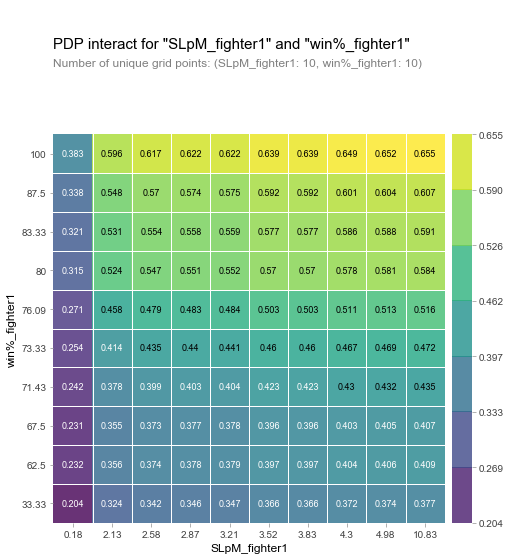

In [18]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

# creating a pdp interact heat map

features = ['SLpM_fighter1', 'win%_fighter1']

plot_params = {
    # color for contour line
    'contour_color':  'white',
    'font_family': 'Arial',
    # matplotlib color map for interact plot
    'cmap': 'viridis',
    # fill alpha for interact plot
    'inter_fill_alpha': 0.8,
    # fontsize for interact plot text
    'inter_fontsize': 9,
}

interaction = pdp_interact(
    model=pipeline, 
    dataset=X_test, 
    model_features=X_test.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

In [19]:
import shap

row = X_test[X_test['fighter1'] == 'Conor McGregor']


explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row
)

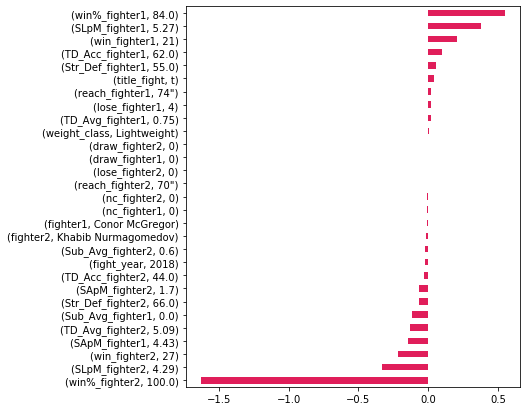

In [20]:
# getting feature importances fot the 

feature_names = row.columns
feature_values = row.values[0]
shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))
shaps.sort_values().plot.barh(color='#E01E5A', figsize=(6,7));

pros = shaps.sort_values(ascending=False)[:3].index
cons = shaps.sort_values(ascending=True)[:3].index

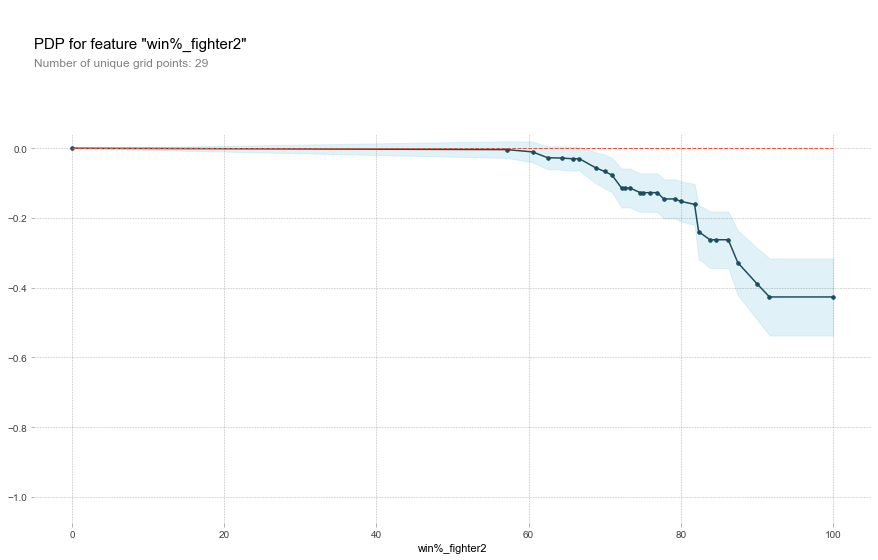

In [21]:
# creating a pdp plot

feature = 'win%_fighter2'

isolated = pdp_isolate(
    model=pipeline, 
    dataset=X_test, 
    model_features=X_test.columns, 
    feature=feature,
    num_grid_points=30
)

pdp_plot(isolated, feature_name=feature);

# pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=100);

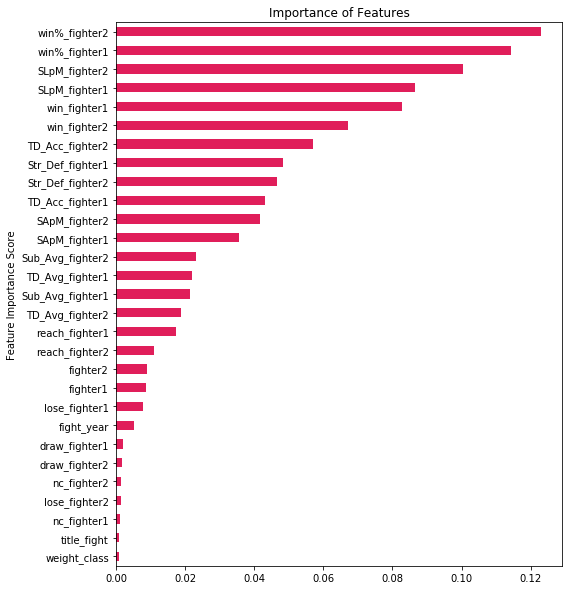

In [27]:
# creating a graph of feature importances
from pylab import rcParams

baseline = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100,max_depth=3, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10)
baseline.fit(X_train_processed,y_train)
predictors=list(X_train)

feat_imp = pd.Series(baseline.feature_importances_, predictors).sort_values(ascending=True)
feat_imp.plot(kind='barh', title='Importance of Features', color='#E01E5A')

plt.ylabel('Feature Importance Score')

rcParams['figure.figsize'] = 2, 10

# #Function to predict the next UFC Fight

In [33]:
ufc_fighter1 = ufc.drop(columns=columns).filter(regex='fighter1').drop_duplicates().sort_values(by=['fighter1'])
ufc_fighter2 = ufc.drop(columns=columns).filter(regex='fighter2').drop_duplicates().sort_values(by=['fighter2'])

In [34]:
def make_pred(fighter_1_input, fighter_2_input):
  fighter_1 = ufc_fighter1[ufc_fighter1['fighter1'].str.match(fighter_1_input)]
  fighter_2 = ufc_fighter2[ufc_fighter2['fighter2'].str.match(fighter_2_input)]

  fighter_1['temp'] = 0
  fighter_2['temp'] = 0
  df = pd.merge(fighter_1, fighter_2, on='temp')
  df = df.drop(columns='temp')

  df['weight_class'] = 'Heavyweight' #weightclass
  df['title_fight'] = 'f' #title
  df['fight_year'] = 2019

  positive_class = 1
  positive_class_index = 1

  row = df.iloc[[0]]
  

  row_processed = processor.transform(row)
    
  # Make predictions (includes predicted probability)
  pred = model.predict(row_processed)[0]
  pred_proba = model.predict_proba(row_processed)[0, positive_class_index]
  pred_proba *= 100
  if pred != positive_class:
    pred_proba = 100 - pred_proba

  if pred == 1:
      pred = 'going to win'
  else:
      pred = 'going to lose'
    
    # Show prediction & probability
  
  str_1 = 'The model predicts '
  str_2 = ' fight is '
  str_3 = ' with '
  str_4 = '% probability.'
  pred_proba = round(pred_proba, 2)
  # print(str_1, row['fighter1'], str_2, pred, str_3, pred_proba, str_4)

  # print("The model predicts  {}  fight is {} with  {} % probability.".format(row.fighter1, pred, pred_proba))

  print(f'The model predicts {list(row.fighter1)} fight is {pred}, with {pred_proba:.0f}% probability.')


  # return df

In [35]:
make_pred('Khabib', 'Conor')

The model predicts ['Khabib Nurmagomedov'] fight is going to win, with 85% probability.
